# MultiGPU training optimization

How many jobs until we start to lose performance?

## Notebook set-up

In [1]:
# Set notebook root to project root
from helper_functions import set_project_root

set_project_root()

# Standard library imports
import multiprocessing as mp
import time
from pathlib import Path

# Third party imports
import matplotlib.pyplot as plt
import pandas as pd

# Local imports
import configuration as config
from model_training import optimize_gpu_workers
from model_training.functions.utils import clear_tensorboard_logs

mp.set_start_method('spawn', force=True)

#clear_tensorboard_logs()

Working directory: /mnt/arkk/kaggle/ariel-data-challenge


## 1.1. Optuna runs

In [ ]:
worker_nums = [1,2,3,4,5,6,7,8]
results_file = f'{config.EXPERIMENT_RESULTS_DIRECTORY}/multiGPU_optimization_worker-{"-".join(map(str, worker_nums))}.csv'

if Path(results_file).exists() == False:
    # Import memory monitoring libraries
    import psutil
    import GPUtil
    import threading
    
    results = {
        'worker_count': [],
        'run_time': [],
        'total_steps': [],
        'max_system_memory_gb': [],
        'avg_system_memory_gb': [],
        'max_gpu0_memory_gb': [],
        'avg_gpu0_memory_gb': [],
        'max_gpu1_memory_gb': [],
        'avg_gpu1_memory_gb': []
    }
    
    def monitor_memory(monitoring_data, stop_event):
        """Monitor system and GPU memory usage in a separate thread"""
        while not stop_event.is_set():
            # System memory
            system_mem = psutil.virtual_memory().used / (1024**3)  # Convert to GB
            monitoring_data['system_memory'].append(system_mem)
            
            # GPU memory
            try:
                gpus = GPUtil.getGPUs()
                if len(gpus) >= 1:
                    gpu0_mem = gpus[0].memoryUsed / 1024  # Convert MB to GB
                    monitoring_data['gpu0_memory'].append(gpu0_mem)
                else:
                    monitoring_data['gpu0_memory'].append(0)
                    
                if len(gpus) >= 2:
                    gpu1_mem = gpus[1].memoryUsed / 1024  # Convert MB to GB
                    monitoring_data['gpu1_memory'].append(gpu1_mem)
                else:
                    monitoring_data['gpu1_memory'].append(0)
            except:
                monitoring_data['gpu0_memory'].append(0)
                monitoring_data['gpu1_memory'].append(0)
            
            time.sleep(0.5)  # Sample every 0.5 seconds

    for workers in worker_nums:
        print(f'Running optimization with {workers} workers')
        
        # Initialize memory monitoring
        monitoring_data = {
            'system_memory': [],
            'gpu0_memory': [],
            'gpu1_memory': []
        }
        stop_event = threading.Event()
        
        # Start memory monitoring thread
        monitor_thread = threading.Thread(target=monitor_memory, args=(monitoring_data, stop_event))
        monitor_thread.start()

        start_time = time.time()

        with mp.Pool(processes=workers) as pool:
            pool.map(optimize_gpu_workers.run, range(workers))

        run_time = time.time() - start_time
        
        # Stop memory monitoring
        stop_event.set()
        monitor_thread.join()

        # Calculate memory statistics
        max_sys_mem = max(monitoring_data['system_memory']) if monitoring_data['system_memory'] else 0
        avg_sys_mem = sum(monitoring_data['system_memory']) / len(monitoring_data['system_memory']) if monitoring_data['system_memory'] else 0
        
        max_gpu0_mem = max(monitoring_data['gpu0_memory']) if monitoring_data['gpu0_memory'] else 0
        avg_gpu0_mem = sum(monitoring_data['gpu0_memory']) / len(monitoring_data['gpu0_memory']) if monitoring_data['gpu0_memory'] else 0
        
        max_gpu1_mem = max(monitoring_data['gpu1_memory']) if monitoring_data['gpu1_memory'] else 0
        avg_gpu1_mem = sum(monitoring_data['gpu1_memory']) / len(monitoring_data['gpu1_memory']) if monitoring_data['gpu1_memory'] else 0
        
        # Store results
        results['run_time'].append(run_time)
        results['worker_count'].append(workers)
        results['total_steps'].append(workers * 4 * 10 * 10)
        results['max_system_memory_gb'].append(max_sys_mem)
        results['avg_system_memory_gb'].append(avg_sys_mem)
        results['max_gpu0_memory_gb'].append(max_gpu0_mem)
        results['avg_gpu0_memory_gb'].append(avg_gpu0_mem)
        results['max_gpu1_memory_gb'].append(max_gpu1_mem)
        results['avg_gpu1_memory_gb'].append(avg_gpu1_mem)
        
        print(f'  Runtime: {run_time:.1f}s, Max System Memory: {max_sys_mem:.1f}GB, Max GPU0: {max_gpu0_mem:.1f}GB, Max GPU1: {max_gpu1_mem:.1f}GB')

        # Wait a bit before starting the next run
        time.sleep(10)

    results_df = pd.DataFrame(results)
    results_df.to_csv(results_file, index=False)

else:
    results_df = pd.read_csv(results_file)

In [3]:
results_df.head()

,worker_count,run_time,total_steps
0,1,555.535504,400
1,2,675.192083,800
2,3,703.719593,1200
3,4,740.246553,1600
4,5,937.910417,2000


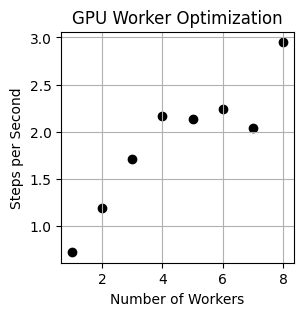

In [ ]:
# Memory usage visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(config.STD_FIG_WIDTH, config.STD_FIG_WIDTH))

# System memory usage
ax1.plot(results_df['worker_count'], results_df['max_system_memory_gb'], 'bo-', label='Max')
ax1.plot(results_df['worker_count'], results_df['avg_system_memory_gb'], 'b^-', label='Avg')
ax1.set_title('System Memory Usage')
ax1.set_xlabel('Number of Workers')
ax1.set_ylabel('Memory (GB)')
ax1.legend()
ax1.grid(True)

# GPU 0 memory usage
ax2.plot(results_df['worker_count'], results_df['max_gpu0_memory_gb'], 'ro-', label='Max')
ax2.plot(results_df['worker_count'], results_df['avg_gpu0_memory_gb'], 'r^-', label='Avg')
ax2.set_title('GPU 0 Memory Usage')
ax2.set_xlabel('Number of Workers')
ax2.set_ylabel('Memory (GB)')
ax2.legend()
ax2.grid(True)

# GPU 1 memory usage
ax3.plot(results_df['worker_count'], results_df['max_gpu1_memory_gb'], 'go-', label='Max')
ax3.plot(results_df['worker_count'], results_df['avg_gpu1_memory_gb'], 'g^-', label='Avg')
ax3.set_title('GPU 1 Memory Usage')
ax3.set_xlabel('Number of Workers')
ax3.set_ylabel('Memory (GB)')
ax3.legend()
ax3.grid(True)

# Memory efficiency (steps per GB of total memory)
total_max_memory = (results_df['max_system_memory_gb'] + 
                   results_df['max_gpu0_memory_gb'] + 
                   results_df['max_gpu1_memory_gb'])
memory_efficiency = results_df['step_rate'] / total_max_memory

ax4.plot(results_df['worker_count'], memory_efficiency, 'ko-')
ax4.set_title('Memory Efficiency')
ax4.set_xlabel('Number of Workers')
ax4.set_ylabel('Steps per Second per GB')
ax4.grid(True)

plt.tight_layout()
plt.show()